---
# Parameter Estimation with Gradient Descent
---
- 서용덕
- yndk@sogang.ac.kr
- Dept. of Global Korean Studies, Sogang University
- code source: https://github.com/deep-learning-with-pytorch/dlwpt-code Chapter 5

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_u.shape

torch.Size([11])

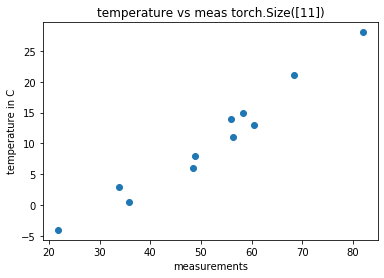

In [5]:
plt.plot(t_u, t_c, 'o')
plt.xlabel('measurements')
plt.ylabel('temperature in C');
plt.title(f'temperature vs meas {t_c.shape}');

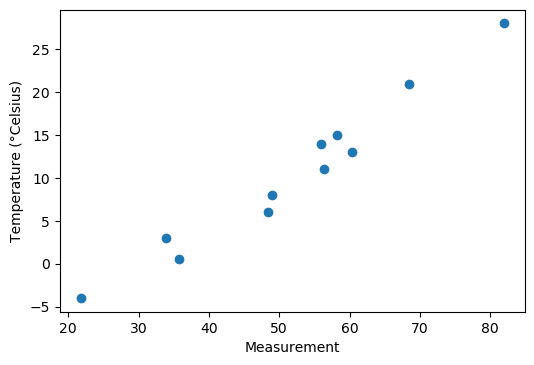

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=100)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

In [5]:
def model(t_u, w, b):
    return w * t_u + b

In [9]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    res = squared_diffs.mean()
    return res

In [12]:
w = torch.ones(())
b = torch.zeros(())
print(w, w.shape)

t_p = model(t_u, w, b)
w, b, t_p

tensor(1.) torch.Size([])


(tensor(1.),
 tensor(0.),
 tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]))

In [13]:
w = torch.tensor(1) # two scalar values
b = torch.tensor(0)
print(w, w.shape)

t_p = model(t_u, w, b)
t_p

tensor(1) torch.Size([])


tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [15]:
loss = loss_fn(t_p, t_c)
loss, loss.item()

(tensor(1763.8846), 1763.8846435546875)

In [16]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}, z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1]), z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


## Numerical Differentiation & GD

In [17]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [18]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [19]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [20]:
loss_rate_of_change_w, loss_rate_of_change_b

(tensor(4517.2979), tensor(-4602.5000))

[tensor(-256403.2500), tensor(-256312.7500), tensor(-256325.2500), tensor(-256452.), tensor(-256439.4844), tensor(-256136.2500), tensor(-256326.5000), tensor(-256390.7500), tensor(-256320.), tensor(-256784.9844)]


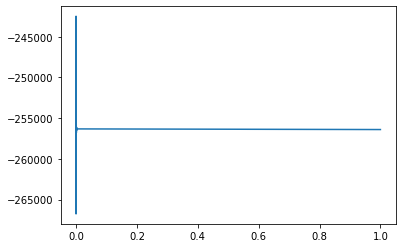

In [21]:
def loss_w(delta):
    return (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

dloss_dw = []
delta = []
for v in range(1, 100000, 100):
    d = 1./v
    dloss_dw.append(loss_w(d))
    delta.append(d)
#
print(dloss_dw[:10])
plt.plot(delta[:200], dloss_dw[:200])

In [22]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

$$
    \frac{d t_p}{dw} = \frac{d}{dw} (w t_u + b)
$$

In [23]:
def dmodel_dw(t_u, w, b):
    return t_u

In [24]:
def dmodel_db(t_u, w, b):
    return 1.0

In [25]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

In [26]:
grad_fn(t_u, t_c, model(t_u, w=1, b=0), w=1, b=0)

tensor([4517.2969,   82.6000])

In [27]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [35]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    loss_values = []
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        loss_values.append(loss.item())
        
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params, loss_values

The learning rate should be taken care of.

In [47]:
params, loss = training_loop(
    n_epochs = 102, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])
...


Reduced learning rate. No diverge, but can be slow


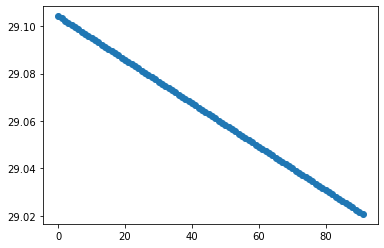

In [49]:
plt.plot(loss[10:], 'o-')

In [26]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

Data normalization is good everytime.

In [52]:
t_u

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [54]:
t_un = 0.1 * t_u
t_un

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])

In [55]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


(tensor([ 2.7553, -2.5162]),
 [80.36434173583984,
  37.57491683959961,
  30.871076583862305,
  29.756193161010742,
  29.50714874267578,
  29.392457962036133,
  29.298828125,
  29.208717346191406,
  29.119417190551758,
  29.030487060546875,
  28.941875457763672,
  28.853565216064453,
  28.76555633544922,
  28.6778507232666,
  28.590431213378906,
  28.503320693969727,
  28.41649627685547,
  28.329975128173828,
  28.243738174438477,
  28.157800674438477,
  28.07215118408203,
  27.986799240112305,
  27.901731491088867,
  27.816953659057617,
  27.732460021972656,
  27.648256301879883,
  27.564342498779297,
  27.480710983276367,
  27.397357940673828,
  27.314294815063477,
  27.23151206970215,
  27.149005889892578,
  27.066789627075195,
  26.984844207763672,
  26.903173446655273,
  26.82179069519043,
  26.74067497253418,
  26.65983772277832,
  26.57927894592285,
  26.498987197875977,
  26.418973922729492,
  26.3392276763916,
  26.25975227355957,
  26.1805477142334,
  26.10161590576172,
  26.0

In [58]:
params, lvs = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, # increased learning rate
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

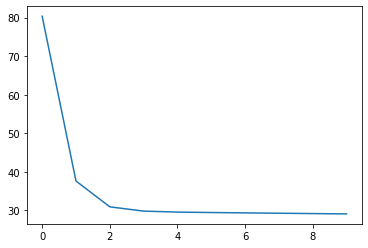

In [62]:
plt.plot(lvs[:10])

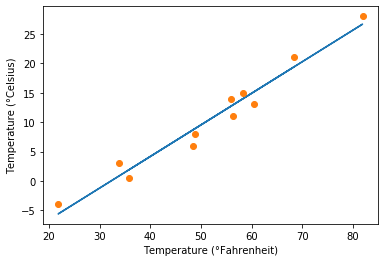

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

#fig = plt.figure(dpi=200)
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.show()
#plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

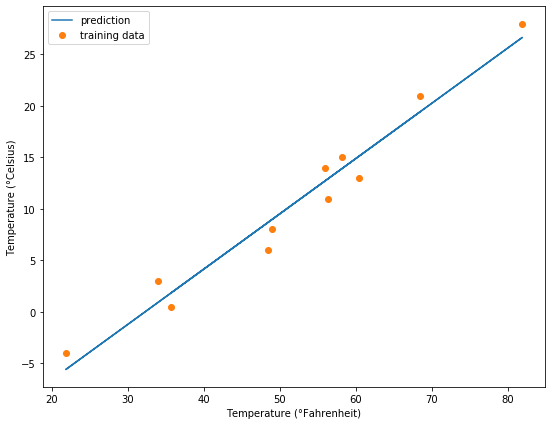

In [31]:
t_p = model(t_un, *params)  # <1>

#fig = plt.figure(dpi=200)
plt.figure(figsize=(9,7))
plt.plot(t_u.numpy(), t_p.detach().numpy(), label='prediction') # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label='training data')
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.legend()

End.

## Assignment 0
- Do the same with $N\times1$ data matrix: $[ [x_1], ..., [x_N]]$
- Do not use AutoGrad nor torch.optim

In [34]:
def polynomial_feature(x_in, deg=5):
    """
        x_in: N x 1 tensor
        return: N x (deg+1) tensor
    """
    print('x_in: ', x_in.shape)
    z = torch.empty(x_in.shape[0], deg)
    for i, x in enumerate(x_in):
        z[i, :] = torch.tensor([np.power(x, n) for n in range(1,deg+1)])
    return z

In [35]:
z_c = polynomial_feature(t_c, deg=1)
z_u = polynomial_feature(t_u, deg=1)

print('t_c: ', t_c, t_c.shape)
print('z_c: ', z_c, z_c.shape)
print('z_u: ', z_u, z_u.shape)

x_in:  torch.Size([11])
x_in:  torch.Size([11])
t_c:  tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000]) torch.Size([11])
z_c:  tensor([[ 0.5000],
        [14.0000],
        [15.0000],
        [28.0000],
        [11.0000],
        [ 8.0000],
        [ 3.0000],
        [-4.0000],
        [ 6.0000],
        [13.0000],
        [21.0000]]) torch.Size([11, 1])
z_u:  tensor([[35.7000],
        [55.9000],
        [58.2000],
        [81.9000],
        [56.3000],
        [48.9000],
        [33.9000],
        [21.8000],
        [48.4000],
        [60.4000],
        [68.4000]]) torch.Size([11, 1])


---
## Auto Grad

In [72]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [74]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [75]:
def model(t_u, w, b):
    return w * t_u + b

In [76]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

### define tensor of auto grad

In [79]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
params

tensor([1., 0.], requires_grad=True)

In [80]:
dir(params)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__se

In [81]:
params.data

tensor([1., 0.])

In [85]:
params.grad_fn

In [84]:
params.grad is None

True

In [40]:
params

tensor([1., 0.], requires_grad=True)

In [88]:
params.data, params.grad, params.grad.data, params.grad_fn

(tensor([1., 0.]),
 tensor([4517.2969,   82.6000]),
 tensor([4517.2969,   82.6000]),
 None)

### Calculate gradient w.r.t all the parameters at the value of the parameter vector provided.

In [89]:
pred = model(t_u, *params)
loss = loss_fn(pred, t_c)
loss.backward() #

print('dloss/dparam = ', params.grad)

dloss/dparam =  tensor([9034.5938,  165.2000])


In [90]:
loss, loss.data, loss.grad, loss.grad_fn

(tensor(1763.8846, grad_fn=<MeanBackward0>),
 tensor(1763.8846),
 None,
 <MeanBackward0 at 0x1dc0860b808>)

In [92]:
# Always zero the grad buffer before backward!
if params.grad is not None:
    params.grad.zero_()

In [93]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [94]:
params = training_loop(
            n_epochs = 5000, 
            learning_rate = 1e-2, 
            params = torch.tensor([1.0, 0.0], requires_grad=True), # <1> 
            t_u = t_un, # <2> 
            t_c = t_c)

params

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [95]:
tlin = torch.linspace(0, 90)
with torch.no_grad():
    t_p = params[0] * tlin *0.1 + params[1]

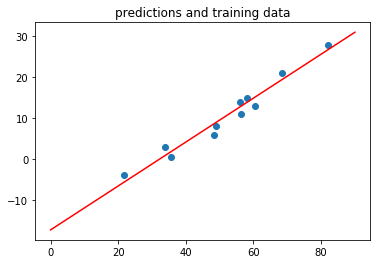

In [98]:
plt.plot(tlin, t_p, 'r-')
plt.scatter(t_u, t_c)
plt.title('predictions and training data');

End.

---
## torch.optim for optimizers

In [99]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [100]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [101]:
def model(t_u, w, b):
    return w * t_u + b

In [102]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [104]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

In [105]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5

optimizer = optim.SGD([params], lr=learning_rate) # stochastic

In [107]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward() # gradient

optimizer.step() # Gradient Descent

params, params.grad

(tensor([ 0.8671, -0.0024], requires_grad=True),
 tensor([8768.8184,  160.5184]))

In [109]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [111]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [112]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

### Adam instead of SGD

In [113]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

### Data split for Training/Validation

In [121]:
vn = 10
ri = torch.randperm(100)
ri[-vn:]

tensor([77, 74, 82, 12, 17, 87, 36, 35, 86,  9])

In [125]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([ 8,  3,  0,  1,  5, 10,  7,  6,  9]), tensor([2, 4]))

In [126]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [127]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(train_loss), float(val_loss)))
            
    return params

In [128]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 85.65538024902344, Validation loss 56.55465316772461
Epoch 2, Training loss 43.96318054199219, Validation loss 11.258879661560059
Epoch 3, Training loss 36.879154205322266, Validation loss 4.2194294929504395
Epoch 500, Training loss 7.154356002807617, Validation loss 2.731245517730713
Epoch 1000, Training loss 3.5517454147338867, Validation loss 2.5742855072021484
Epoch 1500, Training loss 3.1000967025756836, Validation loss 2.5224688053131104
Epoch 2000, Training loss 3.043473482131958, Validation loss 2.504591703414917
Epoch 2500, Training loss 3.036376476287842, Validation loss 2.4983198642730713
Epoch 3000, Training loss 3.0354840755462646, Validation loss 2.4961061477661133


tensor([  5.3719, -17.2278], requires_grad=True)

In [129]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # <1>
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [130]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = calc_forward(train_t_u, train_t_c, is_train=True)

        val_lss = calc_forward(val_t_u, val_t_c, is_train=False)
        assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [131]:
l_eval = calc_forward(t_un, t_c, False)
l_eval

tensor(2.9374)

In [132]:
l_train = calc_forward(t_un, t_c, is_train=True)
l_train

tensor(2.9374, grad_fn=<MeanBackward0>)

End.

---
## Assignment 1
- Solve the same problem with 3rd order polynomial model
$$
    f(x) = w_3 x^3 + w_2 x^2 + w_1 x + b
$$

1. with manually coded gradient function; this can be done simply by using the code of Assignment 0
1. with auto grad
1. with SGD or Adam

For each of the three cases,
1. draw a plot of prediction curve in the range $t_u = [0, 90]$
1. draw a plot of residual vs. epochs

In [133]:
def polynomial_feature(x_in, deg=5):
    """
        x_in: N x 1 tensor
        return: N x (deg+1) tensor
    """
    z = torch.empty(x_in.shape[0], deg)
    for i, x in enumerate(x_in):
        z[i, :] = torch.tensor([np.power(x, n) for n in range(1, deg+1)])
    return z

In [135]:
t_c

tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])

In [136]:
t_c*t_c

tensor([2.5000e-01, 1.9600e+02, 2.2500e+02, 7.8400e+02, 1.2100e+02, 6.4000e+01,
        9.0000e+00, 1.6000e+01, 3.6000e+01, 1.6900e+02, 4.4100e+02])

In [170]:
zu = polynomial_feature(t_u/10., deg=2)

In [142]:
param = torch.tensor([0,1,0.], requires_grad=True)
param

tensor([0., 1., 0.], requires_grad=True)

In [153]:
def model(zu, param):
    pred = torch.mv(zu, param[:-1]) + param[-1]
    return pred

In [154]:
tp = model(zu, param)
tp

tensor([1275.4901, 3125.8101, 3388.2400, 6708.6104, 3170.6899, 2392.2102,
        1150.2101,  476.2400, 2343.5601, 3649.1602, 4679.5601],
       grad_fn=<AddBackward0>)

In [161]:
loss_fn(tp, t_c)

RuntimeError: The size of tensor a (2) must match the size of tensor b (11) at non-singleton dimension 1

In [198]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, params) 
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [206]:
params = torch.tensor([0,9,0.], requires_grad=True)

learning_rate = 1e-5
# optimizer = optim.Adam([params], lr=learning_rate) # <1>
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(1000,
             optimizer,
             params,
             zu,
             t_c)

Epoch 500, Loss 3.884845
Epoch 1000, Loss 3.879891


tensor([-1.3201,  0.6077, -0.2227], requires_grad=True)

---
## Assignment 2
- Solve the problem with 11th order polynomial curve
- Training with optim.SGD or optim.Adam

1. plot residuals vs epochs
1. plot the prediction curve.

End.